In [5]:
import time
import numpy as np
import taichi as ti
import matplotlib.pyplot as plt

ti.init(arch=ti.gpu)

# Number of (x,y) points, including start and end, i.e., d(theta) = 1 / (n1-1)
# The larger this number is, the denser the serrations within the arc for area calculation
n1 = 1000

# Sofa x-coordinate differentiation
n_sofa_dx = 3000

# Sofa width: corridor width is 1, sofa width slightly greater than 3, plus gaps left on both sides
sofa_img_width = 4
world_div_sofa = sofa_img_width / n_sofa_dx

# Resolution of the sofa edge image
sofa_img_dpi = 800

# The upper boundary is limited by y=1 and x=1 on the left and right sides, respectively. The lower boundary is limited by x=0, y=0, (0,0)
sofa_bound = ti.Vector.field(2, ti.f32, shape=n_sofa_dx)

# Position of the first (x,y) point (slightly greater than: sofa width / 2 - 1), which is also the critical point for theta = 0
xy_turn = -0.8

# Iterate for the optimal solution
sofa_area_max = 0

# Initialize trigonometric function values -pi/2 * i/n (0 <= i <= n)
theta_np = np.arange(0, n1) * (-np.pi/2) / (n1-1)
sin_np = np.sin(theta_np)
cos_np = np.cos(theta_np)

# A number close to 0, change it to 0, same as sin_np[0]
cos_np[-1] = 0.0 

sin_field = ti.field(ti.f32, shape=n1)
cos_field = ti.field(ti.f32, shape=n1)
sin_field.from_numpy(sin_np)
cos_field.from_numpy(cos_np)

# Initialize xsin, ycos
xsin = ti.field(ti.f32, shape=n1)
ycos = ti.field(ti.f32, shape=n1)

xsin.from_numpy(sin_np * np.linspace(xy_turn, 0.5, n1, dtype=np.float32))
ycos.from_numpy(cos_np * np.linspace(0.5, xy_turn, n1, dtype=np.float32))

# Initialize mutant backup for xsin, ycos
xsin_backup = ti.field(ti.f32, shape=n1)
ycos_backup = ti.field(ti.f32, shape=n1)

@ti.kernel
def backup_xy():
    for i in range(n1):
        xsin_backup[i] = xsin[i]
        ycos_backup[i] = ycos[i]

@ti.kernel
def revovery_backup_xy():
    for i in range(n1):
        xsin[i] = xsin_backup[i]
        ycos[i] = ycos_backup[i]

################################
# mutate and smooth
################################

@ti.kernel
def smooth_xsin():
    # Ensure the first effective points at the beginning and end remain unchanged
    for i in range(2,n1-2): 
        j = n1-1-i # Reverse direction?
        xsin[j] = xsin[j] * 0.5 + (xsin[j-1] + xsin[j+1]) * 0.5 * 0.5
        
@ti.kernel
def smooth_ycos():
    for i in range(2,n1-2):
        ycos[i] = ycos[i] * 0.5 + (ycos[i-1] + ycos[i+1]) * 0.5 * 0.5

@ti.func
def gaussian_kernel(distance: ti.f32, sigma: ti.f32):
    return ti.exp(-(distance * distance) / (2.0 * sigma * sigma))

@ti.kernel
def mutate_xsin(i_this: ti.i32, delta: ti.f32, sigma: ti.f32):
    for i in range(1,n1):
        xsin[i] += delta * gaussian_kernel(i - i_this, sigma)

@ti.kernel
def mutate_ycos(i_this: ti.i32, delta: ti.f32, sigma: ti.f32):
    for i in range(1,n1):
        ycos[i] += delta * gaussian_kernel(i - i_this, sigma)

################################
# compute area
################################

@ti.kernel
def xy_to_sofa():
    for i in range(n_sofa_dx):
        
        # Scale sofa coordinates to world coordinates
        x_sofa = i * world_div_sofa - sofa_img_width * 0.5
        
        upper_bound = 0.5
        lower_bound = -0.5
        
        for t in range(n1):

            cos_theta = cos_field[t]
            sin_theta = sin_field[t]

            # Sofa center
            x_center = xsin[t]
            y_center = ycos[t]

            if sin_theta < -1e-6: 
                x_center /= sin_theta
            if cos_theta > 1e-6:
                y_center /= cos_theta
            
            # upper_bound = min(min(_, _))
            upper_bound_min = 0.5
            if sin_theta < -1e-6: 
                upper_bound_min = ti.min(upper_bound_min, (1.0 - x_center - cos_theta * x_sofa) / (-sin_theta))
            if cos_theta > 1e-6:
                upper_bound_min = ti.min(upper_bound_min, (1.0 - y_center - sin_theta * x_sofa) / cos_theta)
            upper_bound = ti.min(upper_bound, upper_bound_min)

            # lower_bound = max(min(_, _))
            lower_bound_min = 0.5
            if sin_theta < -1e-6: 
                lower_bound_min = ti.min(lower_bound_min, ( x_center + cos_theta * x_sofa) / sin_theta)
            if cos_theta > 1e-6:
                lower_bound_min = ti.min(lower_bound_min, (-y_center - sin_theta * x_sofa) / cos_theta)
            lower_bound = ti.max(lower_bound, lower_bound_min)

        sofa_bound[i][1] = upper_bound
        sofa_bound[i][0] = lower_bound

@ti.kernel 
def sofa_to_area() -> ti.f32:
    area = 0.0
    for i in range(n_sofa_dx):
        x = sofa_bound[i]
        area += ti.max(x[1] - x[0], 0)
    area *= world_div_sofa
    return area

def xy_to_area():
    xy_to_sofa()
    return sofa_to_area()

################################
# iter
################################

def iter_once(i, f_mutate=None, delta=0.1, sigma=1.0):
    
    global iter_count
    global sofa_area_max
    
    backup_xy()
    f_mutate(i, delta, sigma)
    smooth_xsin()
    smooth_ycos()
    area_new = xy_to_area()

    if area_new > sofa_area_max:
        sofa_area_max = area_new
    else:
        revovery_backup_xy()
    
    iter_count += 1
    if iter_count % 100 == 0:
        speed = int(iter_count / (time.time() - t0 + 1e-6))
        print(f"\rarea_max={sofa_area_max:.5f}, area={area_new:.5f}, speed={speed}/sec, sigma={sigma:.2f}   ", end="")

def get_random_delta():
    return np.clip(np.random.randn() * max(1 - sofa_area_max / 2.2, 0.01), -0.1, 0.1)

[Taichi] Starting on arch=cuda


In [6]:
################################
# plot
################################

def plot_trajectory():

    xs = xsin.to_numpy() / sin_np
    ys = ycos.to_numpy() / cos_np
    xs[0], xs[-1] = xy_turn, 0.5
    ys[0], ys[-1] = 0.5, xy_turn

    # Mark the start and end points specifically
    plt.plot(xs[0], ys[0],   marker='o', markersize=2, color='red')
    plt.plot(xs[-1], ys[-1], marker='o', markersize=2, color='red')
    
    # Draw the (x, y) path
    plt.plot(xs, ys, linestyle='', marker='.', markersize=1, label="Sofa Center Trajectory")
    plt.grid()

    # Draw the vector field along the path
    plt.plot([], [], color='purple', label=r"Sofa $\theta$ (from 0 to $-\pi/2$)")
    for i in range(0, n1, n1 // 20):
        dx = 0.04 * cos_np[i]
        dy = 0.04 * sin_np[i]
        plt.arrow(
            xs[i], ys[i], dx, dy, 
            head_width=0.03, head_length=0.03, 
            fc='purple', ec='purple', 
            alpha=0.5,
        )

    plt.xlim(xy_turn - 0.1, 0.6 + 0.1)
    plt.ylim(xy_turn - 0.1, 0.6 + 0.1)
    plt.legend()
    plt.show()

def plot_xy():

    xsin_np = xsin.to_numpy()
    ycos_np = ycos.to_numpy()
    xs = xsin_np / sin_np
    ys = (ycos_np / cos_np)
    dx = np.gradient(xs) / (-np.pi/2) * (n1-1)
    dy = np.gradient(ys) / (-np.pi/2) * (n1-1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(theta_np,  xsin_np, label=r"$x(\theta) \sin \theta$")
    plt.plot(theta_np,  ycos_np, label=r"$y(\theta) \cos \theta$")
    plt.xlim(0, -np.pi/2) # Invert
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(theta_np, xs, label=r"$x(\theta)$")
    plt.plot(theta_np, ys, label=r"$y(\theta)$")
    plt.xlim(0, -np.pi/2) # Invert
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(theta_np, dx, label=r"$x'(\theta)$")
    plt.plot(theta_np, dy, label=r"$y'(\theta)$")
    plt.xlim(0, -np.pi/2) # Invert
    plt.ylim(-1.5, 1.5) # Truncate range, which is infinite
    plt.legend()
    plt.show()

def plot_sofa():

    ## Below draws the boundary using the envelope method

    sofa_bound_np = sofa_bound.to_numpy()
    lower_bound = np.minimum(sofa_bound_np[:, 0], 0.5)
    upper_bound = np.maximum(sofa_bound_np[:, 1], -0.5)
    xs_bound = np.arange(n_sofa_dx) * sofa_img_width / n_sofa_dx - sofa_img_width * 0.5
    
    ## Below draws the boundary using the differentiation method

    xsin_np = xsin.to_numpy()
    ycos_np = ycos.to_numpy() 
    
    # Edge error if sin or cos is very large
    xs = xsin_np / sin_np
    ys = ycos_np / cos_np

    xs[0], xs[-1] = xy_turn, 0.5
    ys[0], ys[-1] = 0.5, xy_turn
    
    # dx / d(theta), dy / d(theta)
    dxs = np.gradient(xs) * (n1-1) / (-np.pi/2)
    dys = np.gradient(ys) * (n1-1) / (-np.pi/2)

    # Middle arc
    xs_arc = - (xs * cos_np + ys * sin_np)
    ys_arc = xsin_np - ycos_np

    xs_arc[0] = -xy_turn
    xs_arc[-1] = xy_turn
    ys_arc[0] = -0.5
    ys_arc[-1] = -0.5

    # Tangent boundary
    xs_outer_r = dxs * sin_np - (xs-1) * cos_np
    ys_outer_r = xsin_np + dxs * cos_np - sin_np

    xs_inner_r = - (xs * cos_np) + dxs * sin_np
    ys_inner_r = xsin_np + dxs * cos_np

    xs_outer_l = - ((ys-1) * sin_np + dys * cos_np)
    ys_outer_l = dys * sin_np - ycos_np + cos_np

    xs_inner_l = - (ys * sin_np) - dys * cos_np
    ys_inner_l = dys * sin_np - ycos_np

    # Plotting
    plt.figure(figsize=(12, 4), dpi=sofa_img_dpi)
    mask = (upper_bound - lower_bound) > 1e-6
    plt.fill_between(
        xs_bound[mask], lower_bound[mask], upper_bound[mask], 
        label=f"sofa (area={xy_to_area():.4f})", color='lightblue', edgecolor=None
    )
    # plt.plot(xs_bound, lower_bound, marker='', linestyle='-', lw=0.2, ms=0.5, color="pink")
    # plt.plot(xs_bound, upper_bound, marker='', linestyle='-', lw=0.2, ms=0.5, color="pink")

    plt.plot(xs_outer_r, ys_outer_r, marker='', linestyle='-', lw=0.2, ms=0.5, color="orange")
    plt.plot(xs_outer_l, ys_outer_l, marker='', linestyle='-', lw=0.2, ms=0.5, color="orange")
    plt.plot(xs_inner_r, ys_inner_r, marker='', linestyle='-', lw=0.2, ms=0.5, color="orange")
    plt.plot(xs_inner_l, ys_inner_l, marker='', linestyle='-', lw=0.2, ms=0.5, color="orange")
    plt.plot(xs_arc, ys_arc,         marker='', linestyle='-', lw=0.2, ms=0.5, color="green") 
    plt.plot([], [], color="orange", label="bounded by walls")
    plt.plot([], [], color="green",  label="bounded by $(0,0)$")

    plt.xlim(-sofa_img_width/2, sofa_img_width/2)
    plt.ylim(-0.6, 0.6)
    plt.legend()
    plt.savefig("sofa.png")
    plt.show()

def plot_world_snapshots():
    
    sofa_bound_np = sofa_bound.to_numpy()
    xsin_np = xsin.to_numpy()
    ycos_np = ycos.to_numpy()
    
    # 3. Prepare the sofa's local coordinate polygon
    u_coords = np.linspace(-sofa_img_width/2, sofa_img_width/2, n_sofa_dx)
    v_upper = sofa_bound_np[:, 1]
    v_lower = sofa_bound_np[:, 0]
    
    mask = (v_upper - v_lower) > 1e-4
    u_valid = u_coords[mask]
    v_up_valid = v_upper[mask]
    v_lo_valid = v_lower[mask]
    
    # Construct the closed polygon (Sofa Local Frame)
    u_poly = np.concatenate([u_valid, u_valid[::-1]])
    v_poly = np.concatenate([v_up_valid, v_lo_valid[::-1]])
    
    # 4. Prepare for plotting (modified to 1 to 9)
    indices = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    
    # Modified to 3 rows and 3 columns, figsize slightly increased to accommodate 3 rows
    fig, axes = plt.subplots(3, 3, figsize=(15, 15), dpi=100)
    axes = axes.flatten()
    
    # Wall extension length (for plotting)
    wall_ext = 2.0
    
    for k, idx in enumerate(indices):
        ax = axes[k]
        
        # --- A. Calculate transformation ---
        theta = theta_np[idx]
        s_t = sin_np[idx]
        c_t = cos_np[idx]
            
        cx = xsin_np[idx] / s_t
        cy = ycos_np[idx] / c_t
        
        # Transform polygon to World coordinates
        X_poly = u_poly * c_t - v_poly * s_t + cx
        Y_poly = u_poly * s_t + v_poly * c_t + cy
        
        # --- B. Draw scene ---
        
        # 1. Fill "wall" area (gray), leaving the white corridor
        
        # Block 1: Above (y > 1)
        ax.fill_between([-wall_ext, wall_ext], 1, wall_ext, color='#DDDDDD')
        # Block 2: Right (x > 1)
        ax.fill_betweenx([-wall_ext, wall_ext], 1, wall_ext, color='#DDDDDD')
        # Block 3: Inner corner (x < 0 and y < 0)
        ax.fill_between([-wall_ext, 0], -wall_ext, 0, color='#DDDDDD') 
        
        # 2. Draw sofa
        ax.fill(X_poly, Y_poly, label='Sofa')
        ax.set_title(f"$\\theta ={theta/(-np.pi/2):.3f} \\times (-\\pi/2)$")
        ax.set_xlim(-2, 1.5)
        ax.set_ylim(-2, 1.5)

    plt.tight_layout()
    plt.savefig("world.png")
    plt.show()

def plot():
    plot_sofa()
    plot_world_snapshots()
    plot_trajectory()
    plot_xy()

area_max=2.22000, area=2.21999, speed=652/sec, sigma=62.50     

C:\Users\log2c\AppData\Local\Temp\ipykernel_25664\1306106956.py:83: RuntimeWarning: invalid value encountered in divide
  xs = xsin_np / sin_np
C:\Users\log2c\AppData\Local\Temp\ipykernel_25664\1306106956.py:84: RuntimeWarning: divide by zero encountered in divide
  ys = ycos_np / cos_np


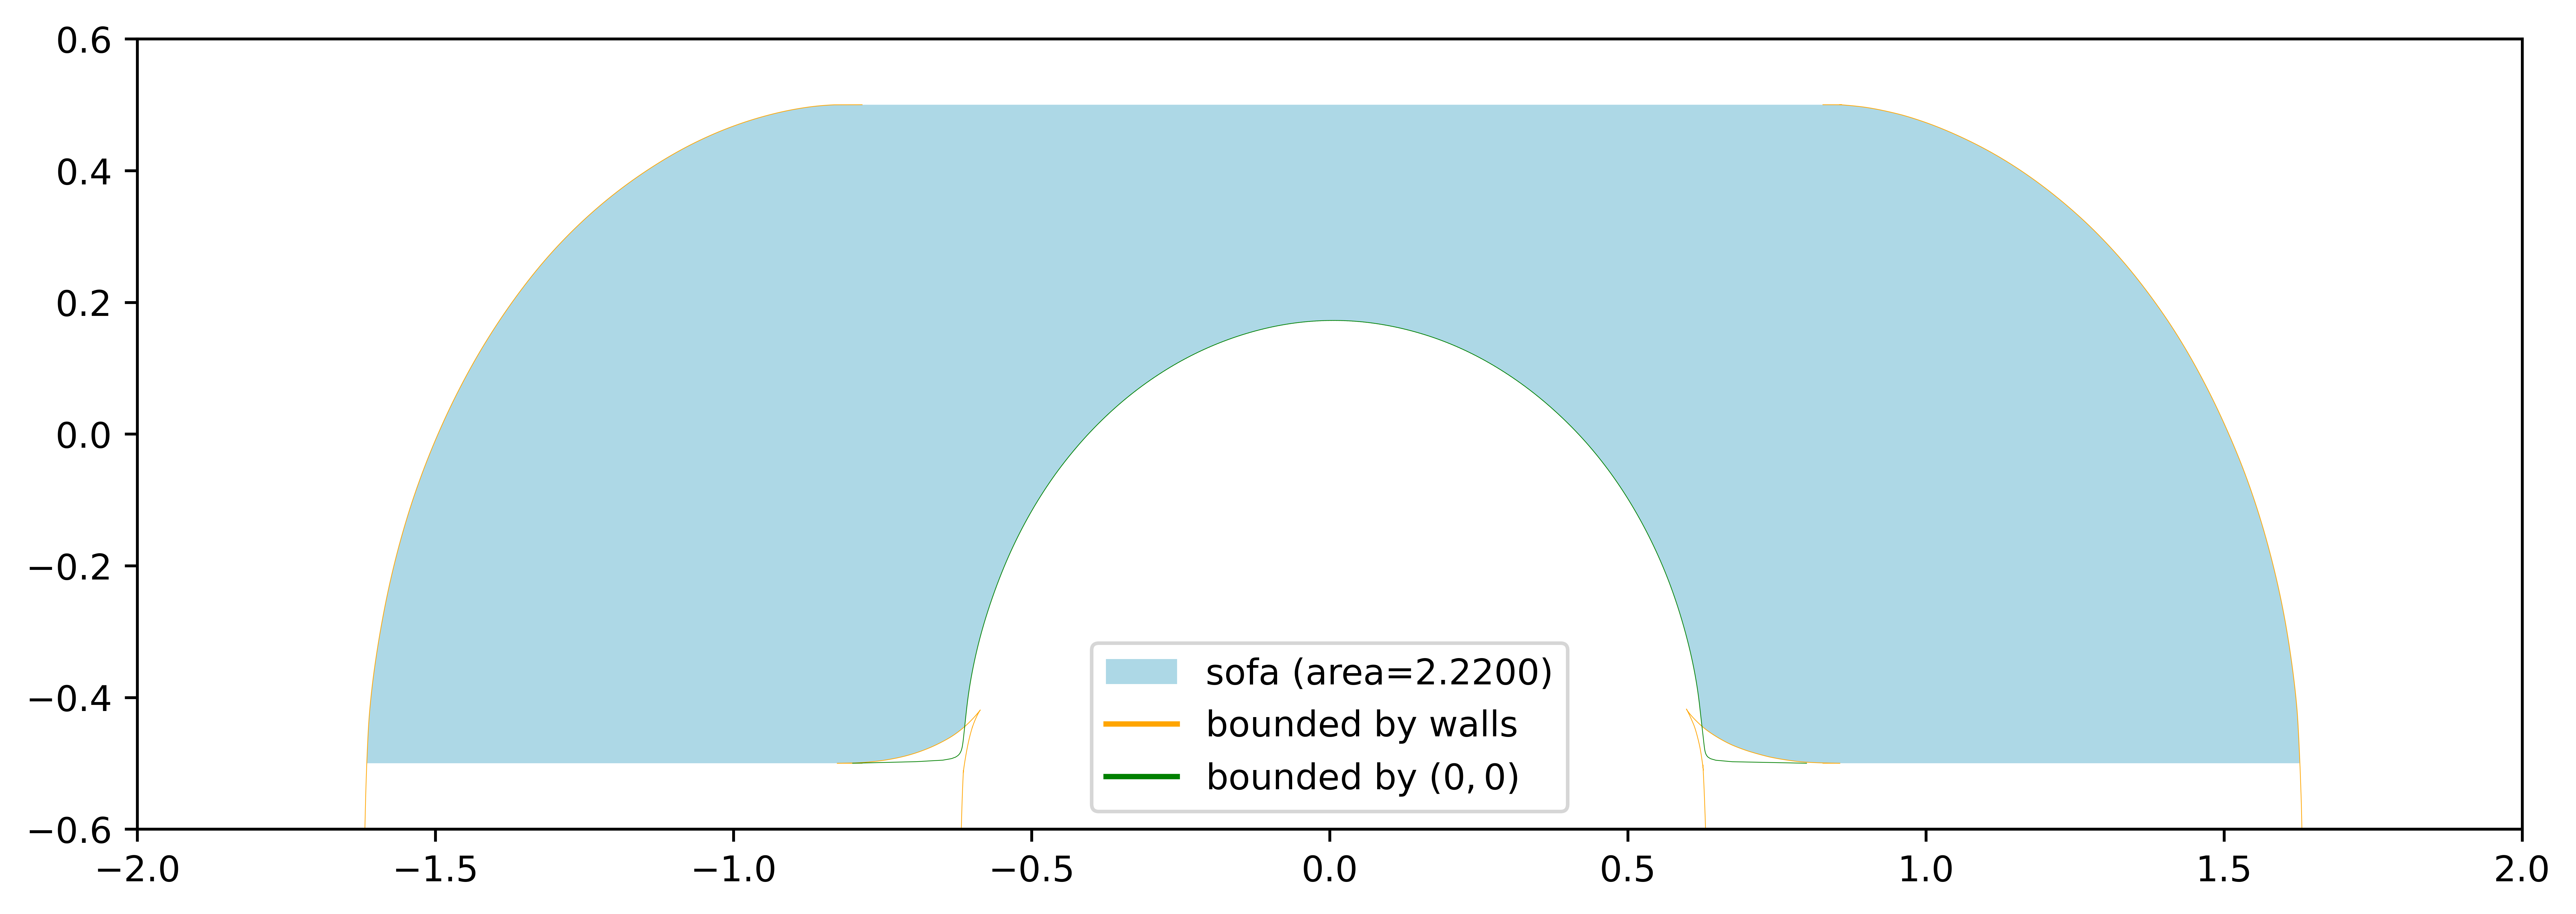

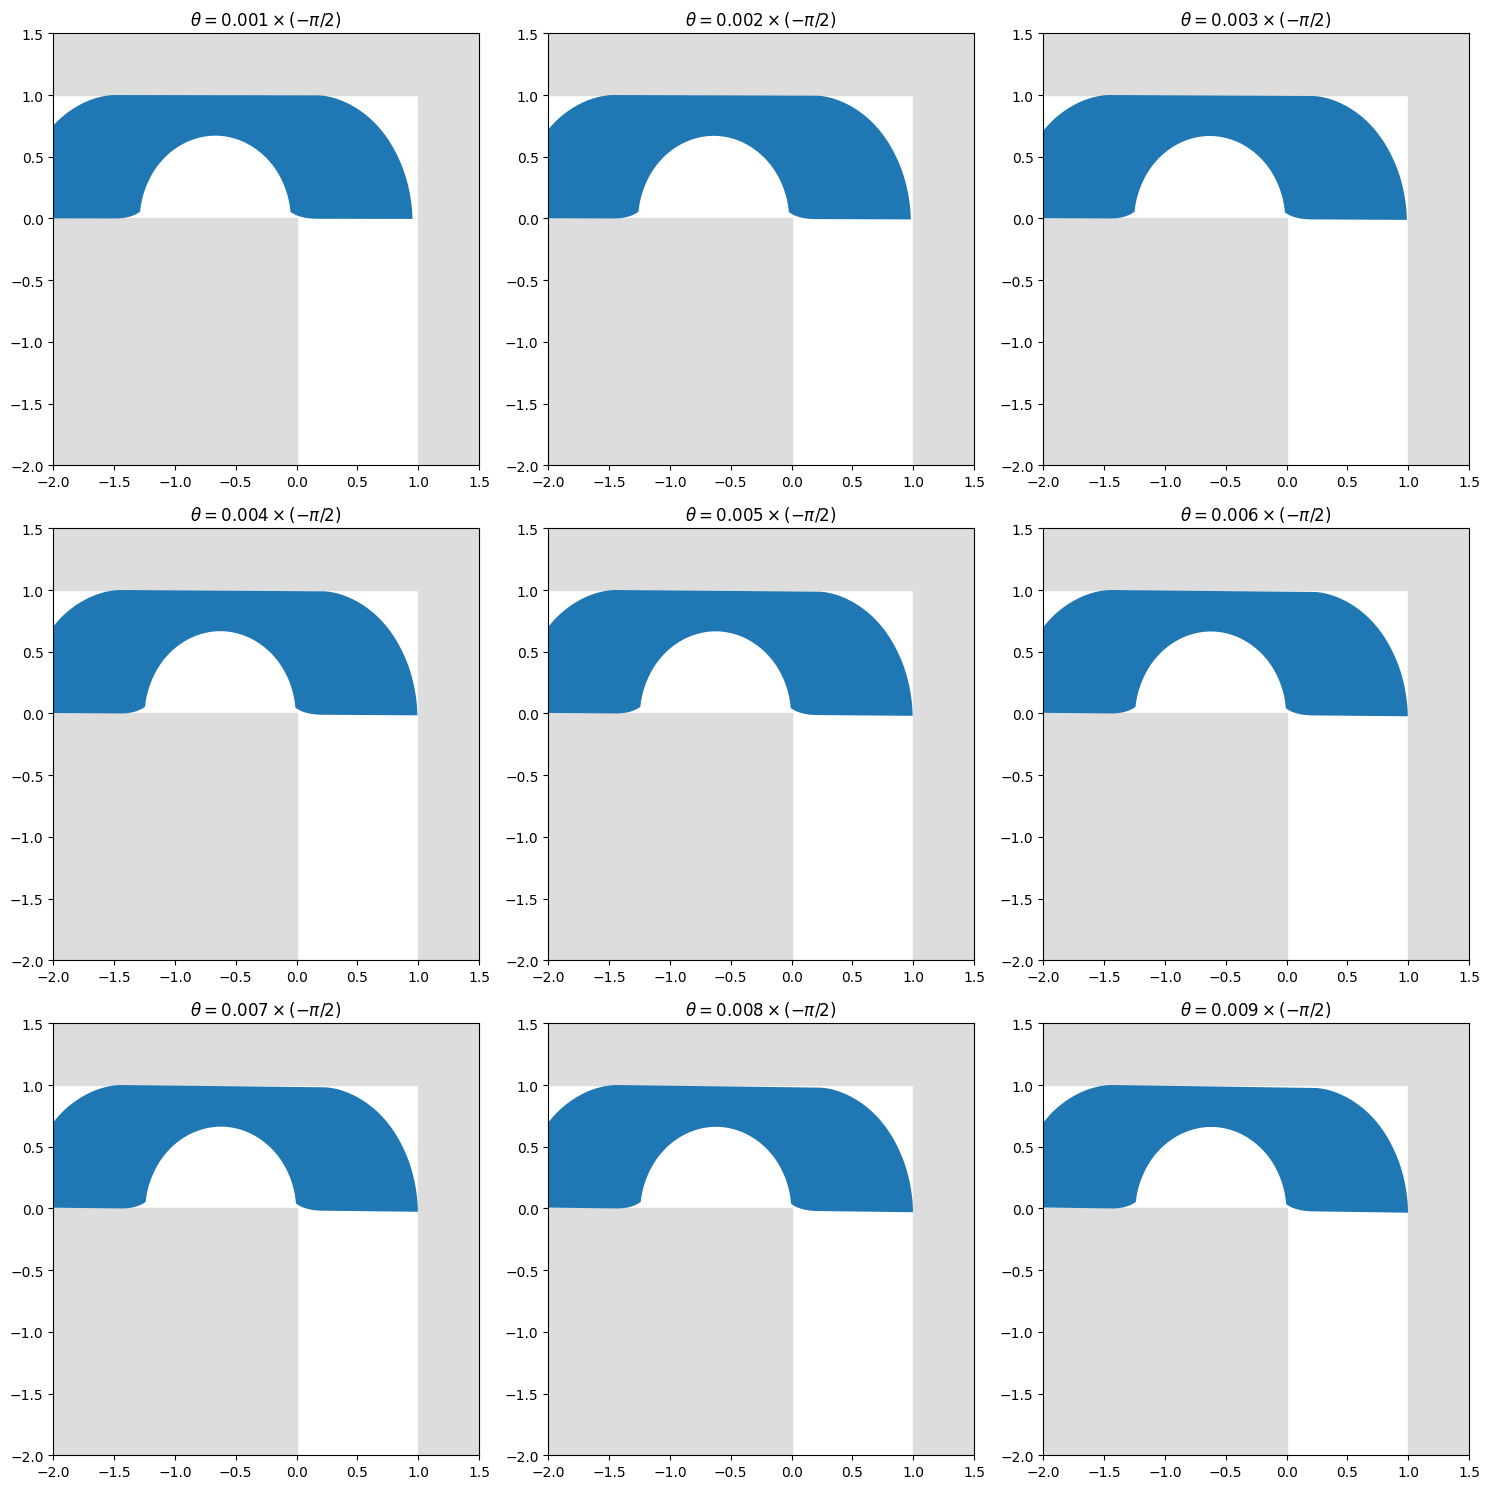

C:\Users\log2c\AppData\Local\Temp\ipykernel_25664\1306106956.py:7: RuntimeWarning: invalid value encountered in divide
  xs = xsin.to_numpy() / sin_np
C:\Users\log2c\AppData\Local\Temp\ipykernel_25664\1306106956.py:8: RuntimeWarning: divide by zero encountered in divide
  ys = ycos.to_numpy() / cos_np


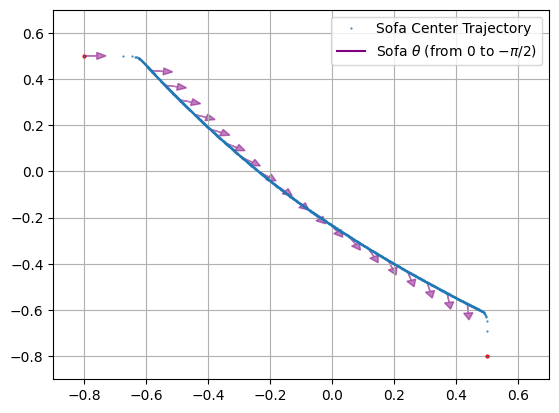

C:\Users\log2c\AppData\Local\Temp\ipykernel_25664\1306106956.py:41: RuntimeWarning: invalid value encountered in divide
  xs = xsin_np / sin_np
C:\Users\log2c\AppData\Local\Temp\ipykernel_25664\1306106956.py:42: RuntimeWarning: divide by zero encountered in divide
  ys = (ycos_np / cos_np)


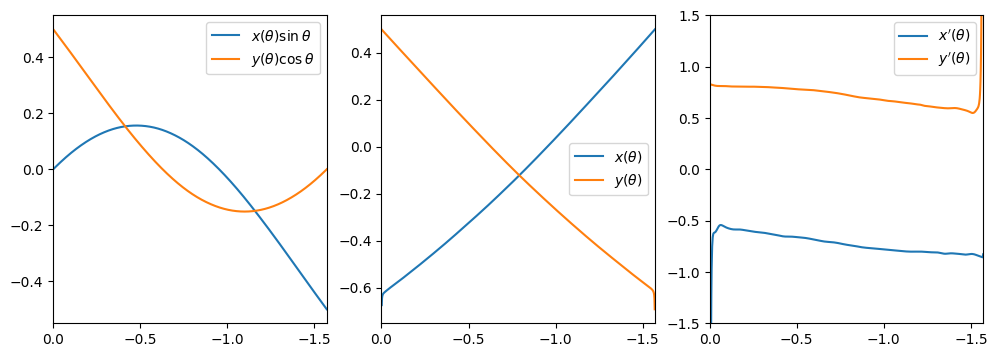

In [15]:
t0 = time.time()
iter_count = 0
try:
    while 1:
        for sigma in (n1, n1//2, n1//4, n1/16, n1/64, n1/256):
            # Start point (0,0), end point (-0.5, -0.5) are fixed
            for i in np.random.permutation(range(1, n1-1)):
                iter_once(i, mutate_xsin, get_random_delta()/sigma, sigma)
                iter_once(n1-1-i, mutate_ycos, get_random_delta()/sigma, sigma)
    
except KeyboardInterrupt:
    # Use the current optimal trajectory to calculate the sofa
    revovery_backup_xy()
    xy_to_area() 
    plot()